In [6]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os, sys, email
import numpy as np 
import pandas as pd
import csv
from tqdm import tqdm
import pandas as pd

from subprocess import check_output

In [13]:
# https://wendy-xiao.github.io/posts/2020-07-10-chuliuemdond_algorithm/
def reverse_graph(G):
    '''Return the reversed graph where g[dst][src]=G[src][dst]'''
    g={}
    for src in G.keys():
        for dst in G[src].keys():
            if dst not in g.keys():
                g[dst]={}
            g[dst][src]=G[src][dst]
    return g

def build_max(rg,root):
    '''Find the max in-edge for every node except for the root.'''
    mg = {}
    for dst in rg.keys():
        if dst==root:
            continue
        max_ind=-100
        max_value = -100
        for src in rg[dst].keys():
            if rg[dst][src]>=max_value:
                max_ind = src
                max_value = rg[dst][src]
        mg[dst]={max_ind:max_value}
    return mg

def find_circle(mg):
    '''Return the firse circle if find, otherwise return None'''
        
    for start in mg.keys():
        visited=[]
        stack = [start]
        while stack:
            n = stack.pop()
            if n in visited:
                C = []
                while n not in C:
                    C.append(n)
                    n = list(mg[n].keys())[0]
                return C
            visited.append(n)
            if n in mg.keys():
                stack.extend(list(mg[n].keys()))
    return None
        
def chu_liu_edmond(G,root):
    ''' G: dict of dict of weights
            G[i][j] = w means the edge from node i to node j has weight w.
            Assume the graph is connected and there is at least one spanning tree existing in G.
        root: the root node, has outgoing edges only.
    '''
    # reversed graph rg[dst][src] = G[src][dst]
    rg = reverse_graph(G)
    # root only has out edge
    rg[root]={}
    # the maximum edge for each node other than root
    mg = build_max(rg,root)
    
    # check if mg is a tree (contains a circle)
    C = find_circle(mg)
    # if there is no circle, it means mg is what we want
    if not C:
        return reverse_graph(mg)
    # Now consider the nodes in the circle C as one new node vc
    all_nodes = G.keys()
    vc = max(all_nodes)+1
    
    #The new graph G_prime with V_prime=V\C+{vc} 
    V_prime = list(set(all_nodes)-set(C))+[vc]
    G_prime = {}
    vc_in_idx={}
    vc_out_idx={}
    # Now add the edges to G_prime
    for u in all_nodes:
        for v in G[u].keys():
            # First case: if the source is not in the circle, and the dest is in the circle, i.e. in-edges for C
            # Then we only keep one edge from each node that is not in C to the new node vc with the largest difference (G[u][v]-list(mg[v].values())[0])
            # To specify, for each node u in V\C, there is an edge between u and vc if and only if there is an edge between u and any node v in C,
            # And the weight of edge u->vc = max_{v in C} (G[u][v] - mg[v].values) The second term represents the weight of max in-edge of v.
            # Then we record that the edge u->vc is originally the edge u->v with v=argmax_{v in C} (G[u][v] - mg[v].values)
            
            if (u not in C) and (v in C):
                if u not in G_prime.keys():
                    G_prime[u]={}
                w = G[u][v]-list(mg[v].values())[0]
                if (vc not in  G_prime[u]) or (vc in  G_prime[u] and w > G_prime[u][vc]):
                    G_prime[u][vc] = w
                    vc_in_idx[u] = v
            # Second case: if the source is in the circle, but the dest is not in the circle, i.e out-edge for C
            # Then we only keep one edge from the new node vc to each node that is not in C
            # To specify, for each node v in V\C, there is an edge between vc and v iff there is an edge between any edge u in C and v.
            # And the weight of edge vc->v = max_{u in C} G[u][v] 
            # Then we record that the edge vc->v originally the edge u->v with u=argmax_{u in C} G[u][v] 
            elif (u in C) and (v not in C):
                if vc not in G_prime.keys():
                    G_prime[vc]={}
                w = G[u][v]
                if (v not in  G_prime[vc]) or (v in  G_prime[vc] and w > G_prime[vc][v]):
                    G_prime[vc][v] = w
                    vc_out_idx[v] = u
            # Third case: if the source and dest are all not in the circle, then just add the edge to the new graph.
            elif (u not in C) and (v not in C):
                if u not in G_prime.keys():
                    G_prime[u]={}
                G_prime[u][v] = G[u][v]
    # Recursively run the algorihtm on the new graph G_prime
    # The result A should be a tree with nodes V\C+vc, then we just need to break the circle C and plug the subtree into A
    # To break the circle, we need to use the in-edge of vc, say u->vc to replace the original selected edge u->v, 
    # where v was the original edge we recorded in the first case above.
    # Then if vc has out-edges, we also need to replace them with the original edges, recorded in the second case above.
    A = chu_liu_edmond(G_prime,root)
    print(A)
    all_nodes_A = list(A.keys())
    for src in all_nodes_A:
        # The number of out-edges varies, could be 0 or any number <=|V\C|
        if src==vc:
            for node_in in A[src].keys():
                orig_out = vc_out_idx[node_in]
                if orig_out not in A.keys():
                    A[orig_out] = {}
                A[orig_out][node_in]=G[orig_out][node_in]
        else:
            for dst in A[src]:
                # There must be only one in-edge to vc.
                if dst==vc:
                    orig_in = vc_in_idx[src]
                    A[src][orig_in] = G[src][orig_in]
                    del A[src][dst]
    del A[vc]
    
    # Now add the edges from the circle to the result.
    # Remember not to include the one with new in-edge
    for node in C:
        if node != orig_in:
            src = list(mg[node].keys())[0]
            if src not in A.keys():
                A[src] = {}
            A[src][node] = mg[node][src]
    return A 

In [7]:
path = 'OrdinalNode-forMaxSpaningTree.csv'
odrinalNode_df = pd.read_csv(path)

In [8]:
path = 'Name-OrindalNumberMapDictionary.csv'
name_number_dict_df = pd.read_csv(path)

# Cluster list

In [9]:
# selct the "Cluster group" value into a list and conduct set operatin and then delete "na" value and then turn back to list
cluster_group_set = set(odrinalNode_df['Cluster group'].dropna()) 
final_cluster_group_list = list(cluster_group_set)

final_cluster_group_list

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]

# The data preparation for the Maximum spanning tree for the current cluster

In [11]:
copy_originalDF_group1 = odrinalNode_df[odrinalNode_df['Cluster group']==13.0]

In [12]:
# Graph construction in the cluster
G = {}

for index, row in copy_originalDF_group1.iterrows():
    sender = row['Sender']
    receiver = row['Receiver']
    weight = row['Weight']
    
    if sender not in G:
        G[sender] = {}
    G[sender][receiver] = weight

G


{2378.0: {1606.0: 14.0,
  1549.0: 49.0,
  910.0: 76.0,
  2047.0: 859.0,
  2393.0: 248.0,
  490.0: 382.0,
  1108.0: 391.0,
  1854.0: 11.0,
  164.0: 38.0,
  615.0: 108.0,
  500.0: 74.0,
  971.0: 4.0,
  98.0: 915.0,
  810.0: 69.0,
  1514.0: 4.0,
  2022.0: 139.0,
  2349.0: 29.0,
  1995.0: 167.0,
  2084.0: 28.0,
  2447.0: 12.0,
  905.0: 11.0,
  1516.0: 28.0,
  1583.0: 8.0,
  1474.0: 7.0,
  632.0: 4.0,
  1233.0: 4.0,
  17.0: 8.0,
  2306.0: 8.0,
  722.0: 7.0,
  917.0: 8.0,
  1362.0: 4.0,
  1628.0: 3.0,
  755.0: 10.0,
  1827.0: 8.0,
  1696.0: 24.0,
  2315.0: 92.0,
  552.0: 4.0,
  1617.0: 14.0,
  1988.0: 23.0,
  1808.0: 8.0,
  712.0: 4.0,
  1001.0: 4.0,
  2482.0: 9.0,
  1279.0: 33.0,
  802.0: 4.0,
  877.0: 4.0,
  2173.0: 8.0,
  197.0: 16.0,
  931.0: 32.0,
  68.0: 8.0,
  2279.0: 4.0,
  907.0: 22.0,
  1603.0: 15.0,
  223.0: 8.0,
  1883.0: 12.0,
  56.0: 4.0,
  2462.0: 17.0,
  2129.0: 4.0,
  2317.0: 9.0,
  189.0: 4.0,
  2431.0: 8.0,
  1180.0: 7.0,
  2391.0: 4.0,
  1146.0: 4.0,
  289.0: 4.0,
  113.0

# Find the most bustlling sender

In [14]:
# find the larget value in the "Weight" and select the value of "Sender" in this row 
max_weight_row = copy_originalDF_group1[copy_originalDF_group1['Weight'] == copy_originalDF_group1['Weight'].max()]
# Select the "Sender" value from this row
largest_weight_sender = int(max_weight_row['Sender'].values[0])
rootNode_in_thisCluster = largest_weight_sender

In [16]:
result =  chu_liu_edmond(G, rootNode_in_thisCluster)

In [18]:
result

{2378.0: {1606.0: 14.0,
  1549.0: 49.0,
  910.0: 76.0,
  2047.0: 859.0,
  2393.0: 248.0,
  490.0: 382.0,
  1108.0: 391.0,
  1854.0: 11.0,
  164.0: 38.0,
  615.0: 108.0,
  500.0: 74.0,
  971.0: 4.0,
  98.0: 915.0,
  810.0: 69.0,
  1514.0: 4.0,
  2022.0: 139.0,
  2349.0: 29.0,
  1995.0: 167.0,
  2084.0: 28.0,
  2447.0: 12.0,
  1516.0: 28.0,
  1583.0: 8.0,
  1474.0: 7.0,
  632.0: 4.0,
  1233.0: 4.0,
  17.0: 8.0,
  2306.0: 8.0,
  722.0: 7.0,
  917.0: 8.0,
  1362.0: 4.0,
  1628.0: 3.0,
  755.0: 10.0,
  1827.0: 8.0,
  1696.0: 24.0,
  2315.0: 92.0,
  552.0: 4.0,
  1617.0: 14.0,
  1988.0: 23.0,
  1808.0: 8.0,
  712.0: 4.0,
  1001.0: 4.0,
  2482.0: 9.0,
  1279.0: 33.0,
  802.0: 4.0,
  877.0: 4.0,
  2173.0: 8.0,
  197.0: 16.0,
  931.0: 32.0,
  68.0: 8.0,
  2279.0: 4.0,
  907.0: 22.0,
  1603.0: 15.0,
  223.0: 8.0,
  1883.0: 12.0,
  56.0: 4.0,
  2462.0: 17.0,
  2129.0: 4.0,
  2317.0: 9.0,
  189.0: 4.0,
  2431.0: 8.0,
  1180.0: 7.0,
  2391.0: 4.0,
  1146.0: 4.0,
  289.0: 4.0,
  113.0: 4.0,
  2089.0

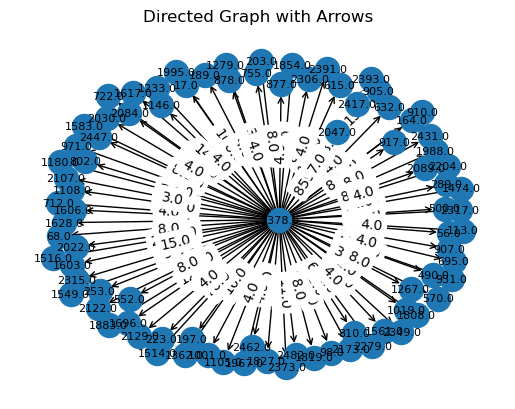

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Graph data
graph_data = result


# Initialize a directed graph
G_directed = nx.DiGraph()

# Add edges to the graph with the provided data
for sender, receivers in graph_data.items():
    for receiver, weight in receivers.items():
        G_directed.add_edge(sender, receiver, weight=weight)

# Draw the directed graph
pos_directed = nx.spring_layout(G_directed)  # positions for all nodes
nx.draw_networkx_nodes(G_directed, pos_directed)
nx.draw_networkx_edges(G_directed, pos_directed, arrowstyle='->', arrowsize=10)
nx.draw_networkx_labels(G_directed, pos_directed, font_size=8, font_family="sans-serif")

# Edge labels for weights
edge_labels_directed = nx.get_edge_attributes(G_directed, 'weight')
nx.draw_networkx_edge_labels(G_directed, pos_directed, edge_labels=edge_labels_directed)

plt.title('Directed Graph with Arrows')
plt.axis('off')  # Turn off the axis
plt.show()
